<a href="https://colab.research.google.com/github/msamunetogetoge/masamune/blob/master/private_preserve_NN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 勾配情報から特徴量を復元する

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
sns.set()

In [0]:
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x.size).reshape(x.shape)
    grad[x>=0] = 1
    
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
   
    return -np.sum(np.log(y[np.arange(y.shape[0]), t] + 1e-7)) / y.shape[0]

In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0
train_images = train_images.flatten().reshape(-1,784)
test_images = test_images.flatten().reshape(-1,784)

In [17]:
ohe = OneHotEncoder( sparse=False)
train_labels = ohe.fit_transform(train_labels.reshape(-1,1))
test_labels = ohe.fit_transform(test_labels.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [0]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1) #tをone hot encording からラベルに戻す 
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        
        #  予測値の計算 (predict と同じ )
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) +b2
        y = softmax(a2)
        
        # 各ノードでの微分の計算。出力側から順々に計算する 
        batch_num = y.shape[0]
        dy = (y - t )/ batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy,axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = relu_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1,axis=0)

        return grads
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y,t)

In [34]:
network =TwoLayerNet(input_size=784, hidden_size=64 , output_size=10)
train_size = train_images.shape[0]
batch_size = 100
iter_num = 5000
learning_rate =0.1

loss_list = []
train_acc_list = []
test_acc_list = []
grad_list = []
iter_per_epoch = 100

for i in np.arange(iter_num):
    batch_mask = np.random.choice(train_size , batch_size)
    x_batch = train_images[batch_mask]
    t_batch = train_labels[batch_mask]
    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]    

    if i % iter_per_epoch == 0:
        grad_list.append(np.linalg.norm(grad["b1"]) )      
        loss = network.loss(x_batch, t_batch)
        loss_list.append(loss)
        train_acc = network.accuracy(train_images, train_labels)
        test_acc = network.accuracy(test_images, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
print("Finish Caluculation")


train acc, test acc | 0.14038333333333333, 0.138
train acc, test acc | 0.6013, 0.5968
train acc, test acc | 0.7079, 0.6954
train acc, test acc | 0.7667833333333334, 0.7616
train acc, test acc | 0.7674666666666666, 0.7561
train acc, test acc | 0.8058166666666666, 0.7918
train acc, test acc | 0.8216333333333333, 0.8107
train acc, test acc | 0.8014, 0.789
train acc, test acc | 0.8313166666666667, 0.8193
train acc, test acc | 0.8348666666666666, 0.8229
train acc, test acc | 0.8286, 0.8128
train acc, test acc | 0.83955, 0.8263
train acc, test acc | 0.8399833333333333, 0.8239
train acc, test acc | 0.8449, 0.8313
train acc, test acc | 0.8503833333333334, 0.8343
train acc, test acc | 0.8297833333333333, 0.8176
train acc, test acc | 0.8476666666666667, 0.8344
train acc, test acc | 0.84635, 0.831
train acc, test acc | 0.8543, 0.8414
train acc, test acc | 0.8543, 0.8367
train acc, test acc | 0.8551, 0.8397
train acc, test acc | 0.8529333333333333, 0.8395
train acc, test acc | 0.8582166666666666, 

In [0]:
grads_list[0]["W1"][:,0]

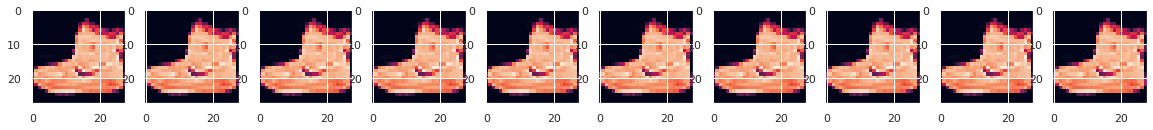

In [45]:
plt.figure(figsize=(20,10))
for i in range(10):
    im= grads_list[i]["W1"][:,0]/grads_list[i]["b1"][0] 
    im = im.reshape(28,28)
    plt.subplot(1,10,1+i)
    plt.imshow(im)
    plt.savefig("from_grads.png")

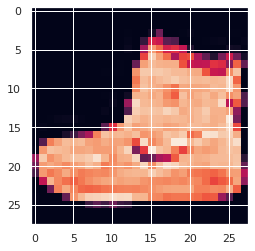

In [22]:
plt.imshow(train_images[0].reshape(28,28))
plt.savefig("real_feature.png")